# Quantifying uncertainties in 2D seismic wave propagation
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/vae_keras_gaussian2d.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
    
  <td>
    <a target="_blank" href="https://github.com/medicinely/fwi/blob/main/vae_keras_gaussian2d.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

In [1]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

## Import libraries

In [1]:
# import sys, importlib
# importlib.reload(sys.modules['med.func.inversion'])
# importlib.reload(sys.modules['func.propagation_tf'])

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

from func.propagation import prop2d, defmodel
from func.propagation_tf import simulate_obs
from func.inversion import gradiant
# from func.velocity_model import check_model, gaussian2d

2023-01-13 13:46:49.375292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 13:46:49.664661: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-13 13:46:49.696648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-13 13:46:49.696671: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Calcualte d_obs

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  29 29 235
Number of receivers: 9
shape of p(z,x,t) = (29, 29, 235)


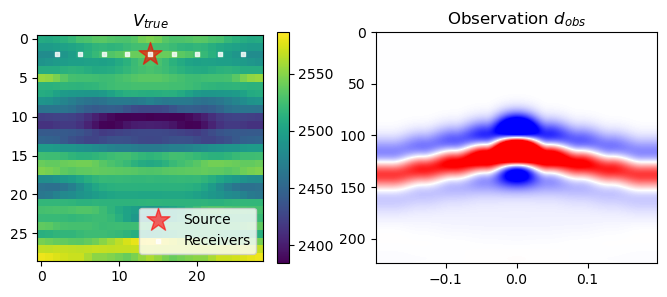

J = 11.1022787094
4.451510429382324
gradient shape: (29, 29)


In [3]:
# Import true model and observation
import pickle
filename = './data/v_ref'
infile = open(filename, 'rb')
v_ref = pickle.load(infile)
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 29,29,235
vmin,vmax=2000,3000
izsrc, ixsrc = [nz//10], [nx//2]
next = 10

# v_ref = gaussian2d(ranges=[20,5],variance=50,nx=[nz,nx],param=1,mean=2500)
v_ref = .5* (v_ref + v_ref[:,::-1])

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  

# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 3 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
print("Number of receivers:", len(zxrec.flatten())//2)
# # Simulate real observation
p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device='cpu')
print("shape of p(z,x,t) =", p.shape)
d_obs = p[zxrec[0], zxrec[1], :]


plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()


# Test code
optimizer = tf.keras.optimizers.Adam(learning_rate=1)
v = tf.Variable(np.zeros([nz, nx]) + 2500, dtype=tf.float32)
for i in range(10):
	with tf.GradientTape() as tape:
		tape.watch(v)
		d = simulate_obs(v, wsrc, zxsrc, at, az, ax, next, zxrec)
		# Calculate loss "J"
		loss = .5 * tf.reduce_sum((d - d_obs)**2)
		print(loss)
		g = tape.gradient(loss, v)
	optimizer.apply_gradients(zip(g, [v]))
# print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))
print(time.time()-start)
print("gradient shape:", g.shape)
# plt.figure(figsize=(3,3))
# plt.imshow(g)

## Functions - tf 2D propagation

## $Gradiant  = \frac{\mathrm{d} J}{\mathrm{d} v}$

0.06870675086975098


Text(0.5, 1.0, 'Difference')

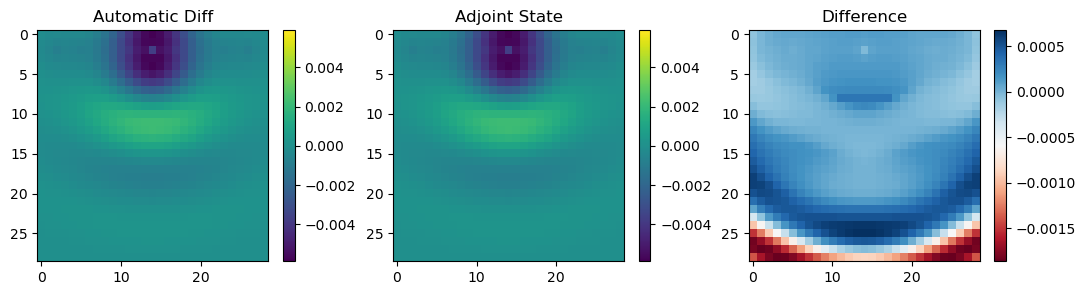

In [5]:
maxi = np.max(abs(g))
plt.figure(figsize=(13,3))
plt.subplot(1,3,1)
plt.imshow(g,vmin=-maxi,vmax=+maxi)
plt.colorbar()
plt.title("Automatic Diff")
plt.subplot(1,3,2)
start = time.time()
g_adj = gradiant(v.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device='cpu').reshape(nz,nz)
print(time.time()-start)
plt.imshow(g_adj,vmin=-maxi,vmax=+maxi)
plt.colorbar()
plt.title("Adjoint State")
plt.subplot(1,3,3)
plt.imshow((g-g_adj)/(np.abs(g_adj)+1e-3),cmap="RdBu")
plt.colorbar()
plt.title("Difference")

## Encoder

In [14]:
latent_dim = 2
img_width, img_height = 29,29
# acfunc = "tanh" #relu
# acfunc2 = "tanh" #sigmoid
acfunc = "relu" 
acfunc2 = "sigmoid" 

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(img_width, img_height, 1))
x = layers.Conv2D(32, 3, activation=acfunc, strides=2, padding="valid")(encoder_inputs)
x = layers.Conv2D(64, 3, activation=acfunc, strides=2, padding="same")(x)
conv_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(16, activation=acfunc)(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 29, 29, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 32)   320         ['input_8[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_6[0][0]']               
                                                                                                  
 flatten_3 (Flatten)            (None, 3136)         0           ['conv2d_7[0][0]']               
                                                                                            

## Decoder

In [15]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation=acfunc)(latent_inputs)
x = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation=acfunc, strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation=acfunc, strides=2, padding="valid")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation=acfunc2, padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 29, 29, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 29, 29, 1)        289 

## Train the VAE

Epoch 1/5000
1/1 [==============================] - 0s 252ms/step - loss: 583.3847 - reconstruction_loss: 583.3813 - kl_loss: 0.0034
Epoch 2/5000
1/1 [==============================] - 0s 41ms/step - loss: 581.3717 - reconstruction_loss: 581.3418 - kl_loss: 0.0299
Epoch 3/5000
1/1 [==============================] - 0s 46ms/step - loss: 579.6931 - reconstruction_loss: 579.6811 - kl_loss: 0.0120
Epoch 4/5000
1/1 [==============================] - 0s 49ms/step - loss: 578.4150 - reconstruction_loss: 578.4073 - kl_loss: 0.0077
Epoch 5/5000
1/1 [==============================] - 0s 44ms/step - loss: 574.4437 - reconstruction_loss: 574.4055 - kl_loss: 0.0383
Epoch 6/5000
1/1 [==============================] - 0s 42ms/step - loss: 568.7779 - reconstruction_loss: 568.7099 - kl_loss: 0.0680
Epoch 7/5000
1/1 [==============================] - 0s 40ms/step - loss: 571.1920 - reconstruction_loss: 571.0822 - kl_loss: 0.1098
Epoch 8/5000
1/1 [==============================] - 0s 43ms/step - loss: 56

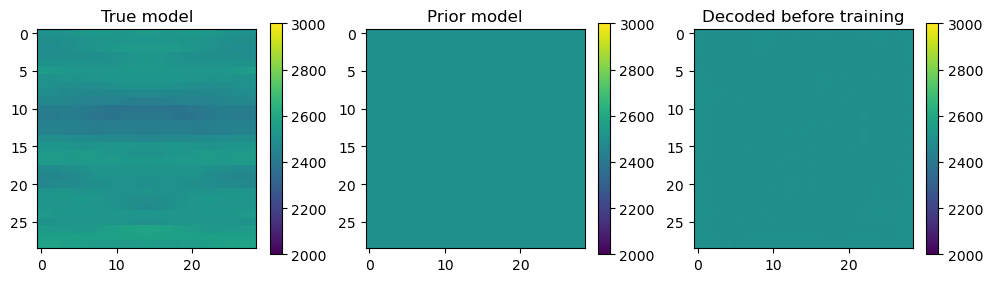

In [16]:
# Set prior velocity field (29,29)
prior = np.zeros([nz, nx]) + 2500
# prior = v_ref
prior = prior/3000
prior = prior.reshape(1,img_width,img_height,1)

class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(
        name="reconstruction_loss"
    )
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + 1*kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(prior, epochs=5000, batch_size=1, verbose=1)

# Decode prior to latent prior distribution
mu, sig, z = vae.encoder.predict(prior)
input = prior.reshape(img_width,img_height)
output = vae.decoder.predict(mu).reshape(img_width,img_height)
# Re-scale the image
input = input*3000
output = output*3000
loss = np.abs(input - output)/(nz*nx)
print("Average loss:",loss.sum())


maxi = np.max(np.abs(v_ref))
mini = np.min(np.abs(v_ref))
plt.figure(figsize=(12,3))
# output image
plt.subplot(1,3,1)
print("Reference mean:",v_ref.mean())
plt.imshow(v_ref,vmin=mini,vmax=maxi)
plt.colorbar()
plt.title("True model")

# Input image
plt.subplot(1,3,2)
print("Input mean:",input.mean())
plt.imshow(input,vmin=mini,vmax=maxi)
plt.colorbar()
plt.title("Prior model")

# output image
plt.subplot(1,3,3)
print("Output mean:",output.mean())
plt.imshow(output,vmin=mini,vmax=maxi)
plt.colorbar()
plt.title("Decoded before training")
plt.show()

## Define the VAE as a `Model` with a custom `train_step`

In [25]:
# Start training
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.loss_tracker = keras.metrics.Mean(name="loss")
  @property
  def metrics(self):
    return [
        self.loss_tracker,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        v = 3000 * tf.reshape(reconstruction,[nz,nx])
        d = simulate_obs(v, wsrc, zxsrc, at, az, ax, next, zxrec)
        loss = .5 * tf.reduce_sum((d - d_obs)**2)
    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.loss_tracker.update_state(loss)
    return {
        "loss": self.loss_tracker.result(),
    }
opt = keras.optimizers.Adam(learning_rate=0.0000001)
vae = VAE(vae.encoder, vae.decoder)
vae.compile(optimizer=opt, run_eagerly=True)
vae.fit(prior, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 10.6601
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 11.7355
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 11.7226
Epoch 4/50
1/1 [==============================] - 4s 4s/step - loss: 11.3362
Epoch 5/50
1/1 [==============================] - 4s 4s/step - loss: 11.2800
Epoch 6/50
1/1 [==============================] - 4s 4s/step - loss: 11.1609
Epoch 7/50
1/1 [==============================] - 4s 4s/step - loss: 11.5383
Epoch 8/50
1/1 [==============================] - 4s 4s/step - loss: 11.4887
Epoch 9/50
1/1 [==============================] - 4s 4s/step - loss: 10.8851
Epoch 10/50
1/1 [==============================] - 5s 5s/step - loss: 11.6705
Epoch 11/50
1/1 [==============================] - 5s 5s/step - loss: 11.2251
Epoch 12/50
1/1 [==============================] - 5s 5s/step - loss: 11.2090
Epoch 13/50
1/1 [==============================] - 5s 5s/step - loss: 11.

## Generate new image

1/1 [==============================] - 0s 30ms/step
Average loss: 0.6705660462804697
Reference mean: 2501.593178334631
Input mean: 2500.0
Output mean: 2499.8506


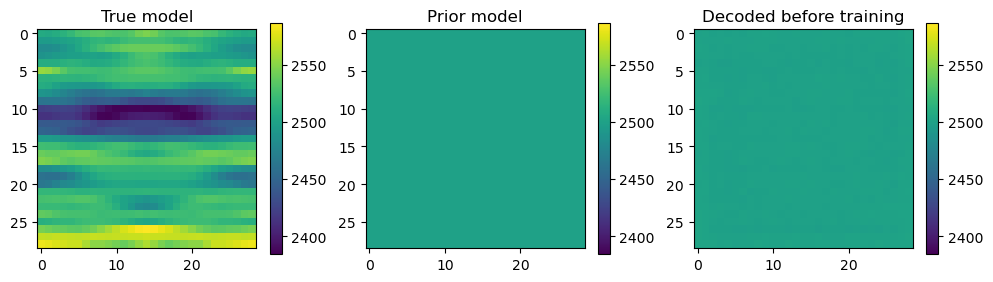

In [27]:
# Decode prior to latent prior distribution
mu, sig, z = vae.encoder.predict(prior)
input = prior.reshape(img_width,img_height)
output = vae.decoder.predict(mu).reshape(img_width,img_height)
# Re-scale the image
input = input*3000
output = output*3000
loss = np.abs(input - output)/(nz*nx)
print("Average loss:",loss.sum())


maxi = np.max(np.abs(v_ref))
mini = np.min(np.abs(v_ref))
plt.figure(figsize=(12,3))
# output image
plt.subplot(1,3,1)
print("Reference mean:",v_ref.mean())
plt.imshow(v_ref,vmin=mini,vmax=maxi)
plt.colorbar()
plt.title("True model")

# Input image
plt.subplot(1,3,2)
print("Input mean:",input.mean())
plt.imshow(input,vmin=mini,vmax=maxi)
plt.colorbar()
plt.title("Prior model")

# output image
plt.subplot(1,3,3)
print("Output mean:",output.mean())
plt.imshow(output,vmin=mini,vmax=maxi)
plt.colorbar()
plt.title("Decoded before training")
plt.show()

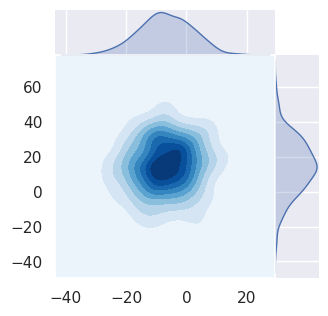

In [ ]:
def show_posterior(mu,sig):
  mean = [mu[0,0], mu[0,1]]
  cov = [[sig[0,0]**2, 0], [0, mu[0,1]**2]]

  x, y = np.random.multivariate_normal(mean, cov, 500).T
  # sns.set_style("darkgrid")
  ax = sns.jointplot(x=x,y=y,kind="kde",space=0,fill=True,
                    thresh=0,cmap='Blues',joint_kws={'alpha': 1})
  ax.fig.set_size_inches(3,3)

show_posterior(mu,sig)